<a href="https://colab.research.google.com/github/liamharcombe4/eigen-network/blob/main/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

Data

In [ ]:
kappaInit = np.array([1,1,1,1,1,1,1,1,1,1])

def kappaFun(x):
  if 0 <= x and x < 0.1:
    return kappaInit[0]
  elif 0.1 <= x < 0.2:
    return kappaInit[1]
  elif 0.2 <= x < 0.3:
    return kappaInit[2]
  elif 0.3 <= x < 0.4:
    return kappaInit[3]
  elif 0.4 <= x < 0.5:
    return kappaInit[4]
  elif 0.5 <= x < 0.6:
    return kappaInit[5]
  elif 0.6 <= x < 0.7:
    return kappaInit[6]
  elif 0.7 <= x < 0.8:
    return kappaInit[7]
  elif 0.8 <= x < 0.9:
    return kappaInit[8]
  elif 0.9 <= x <= 1:
    return kappaInit[9]
  else:
    return 0
  
# The number of nodes. Can be changed freely.
n = 100

x = np.linspace(0,1,n)
ev = tf.Variable(np.ones((1)), trainable=True)
evec = tf.Variable(np.random.rand(10,), trainable=True)
evec_size = n
h = x[1] - x[0]
train_output = tf.ones([n,])
train_inputs = tf.reshape(tf.tile(x, [1]), [1, n])
train_outputs = tf.reshape(tf.tile(train_output, [1]), [1, n])
kappa = np.array([kappaFun(xn) for xn in x])

# Calculate derivative at left endpoint (Error found below, u1 t0 u0 for the first term, QD)
def leftEndDer(u0,u1,u2):
  return -3/(2*h)*u0 + 2/h*u1 - 1/(2*h)*u2

# Calculate derivative at right endpoint
def rightEndDer(un2,un1,un0):
  return 3/(2*h)*un0 - 2/h*un1 + 1/(2*h)*un2

# Calculate derivative at inner point (non-endpoint)
def innerDer(p0,p2):
  return (p2-p0)/(2*h)

# Calculate the derivative vector
# firstDer is defined differently to secondDer as kappa*y_pred has a different shape to y_pred
def firstDer(vector):
  vector_num = vector

  left_der = leftEndDer(vector[0][0],vector[0][1],vector[0][2])
  right_der = leftEndDer(vector[0][-3],vector[0][-2],vector[0][-1])

  processed = [left_der]
  unstacked = tf.unstack(vector[0])
  for i in range(0,len(unstacked)-2):
    processed.append(innerDer(unstacked[i], unstacked[i+2]))
  
  processed.append(right_der)

  return tf.stack(processed, 0)

def secondDer(vector):
  vector_num = vector

  left_der = leftEndDer(vector[0],vector[1],vector[2])
  right_der = leftEndDer(vector[-3],vector[-2],vector[-1])

  processed = [left_der]
  unstacked = tf.unstack(vector)
  for i in range(0,len(unstacked)-2):
    processed.append(innerDer(unstacked[i], unstacked[i+2]))
  
  processed.append(right_der)

  return tf.stack(processed, 0)

Model

In [ ]:
sin = tf.math.sin

# Input only the x values
inputs = tf.keras.Input(shape=(n,1))

# For eigenvalue
a = tf.keras.layers.Dense(300, activation="relu")(inputs)
a = tf.keras.layers.Dense(200, activation="relu")(a)
a = tf.keras.layers.Flatten()(a)
ev_out = tf.keras.layers.Dense(1)(a)

# For eigenfunction
b = tf.keras.layers.Dense(300, activation="relu")(inputs)
b = tf.keras.layers.Dense(300, activation=sin)(b)
b = tf.keras.layers.Dense(300, activation="relu")(b)
b = tf.keras.layers.Flatten()(b)
evec_out = tf.keras.layers.Dense(n)(b)

outputs = tf.keras.layers.Concatenate(axis=1)([ev_out, evec_out])

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")

def midpoint_area(p1,p2):
  return h*(p2+p1)/2

def integral(tensor):
  processed = []
  unstacked = tf.unstack(tensor)
  for i in range(0,len(unstacked)-1):
    processed.append(midpoint_area(unstacked[i], unstacked[i+1]))

  return tf.math.reduce_sum(tf.stack(processed, 0))


epochs = 130000

@tf.autograph.experimental.do_not_convert
def my_loss(y_true, y_pred):
  
  ev = y_pred[0][0]
  evec = y_pred[0][1:]
  D = tf.math.sqrt(tf.math.reduce_mean((secondDer(kappa*secondDer(evec)) + ev*evec)**2))
  
  return D + 1/h**2*(evec[0]**2 + evec[-1]**2 + (integral(evec) - 1)**2)

model.compile(
    loss = my_loss,
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
)

ev_list = []
evec_list = []

In [ ]:
%%time
for i in range(epochs):
    epoch = np.repeat(float(i), n)

    # make train outputs the epoch number to be used in the loss function

    epoch_tile = tf.reshape(tf.tile(epoch, [1]), [1,n])

    model.fit(train_inputs, epoch_tile, epochs=1, verbose=0)

    #every 1000 epochs output the ev and evec predictions
    if (i % 1000 == 0):
      ev_fun = K.function([model.layers[0].input], model.layers[-3].output)
      ev = ev_fun(train_inputs)[0]
      ev_list.append(ev)

      evec_fun = K.function([model.layers[0].input], model.layers[-2].output)
      evec = evec_fun(train_inputs)[0]
      evec_list.append(evec)
      print("epoch:", i, "ev:", ev)

KeyboardInterrupt: ignored

Results and Testing

1/1 [==============================] - 0s 16ms/step
average evec percentage error in non-endpoint coordinates: 53.7299%
ev percentage error: 79.84434953197793% where true = 9.869604401089358 and pred = 1.9892828


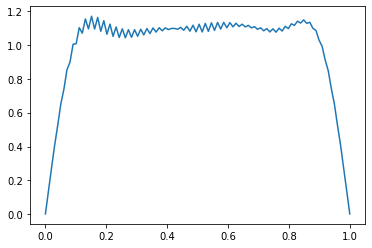

In [ ]:
ev_pred = model.predict(train_inputs)[0][0]
evec_pred = model.predict(train_inputs)[0][1:]
evec_true = np.array([np.pi/2*np.sin(np.pi*xi) for xi in x])
ev_true = np.pi**2

ev_error = abs((ev_pred - ev_true)/ev_true)
evec_error = np.array([abs((x - y)/y) for x, y in zip(evec_pred[1:-1], evec_true[1:-1])]).mean()

print("average evec percentage error in non-endpoint coordinates:", str(round(100*evec_error, 4)) + "%")
print("ev percentage error:", str(round(100*ev_error, 20)) + "%", "where true =", round(ev_true,20), "and pred =", round(ev_pred,20))
plt.plot(x, evec_pred)
plt.show()

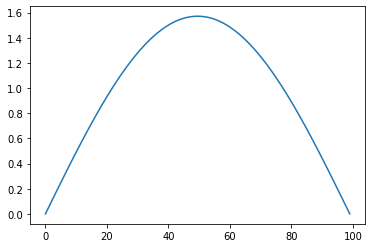

In [ ]:
plt.plot(evec_true)
plt.show()

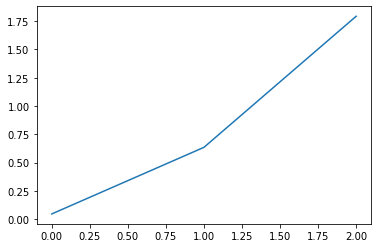

In [ ]:
plt.plot(ev_list)

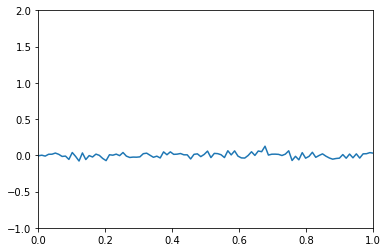

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(-1,2)
line, = ax.plot(0,0)

xs = np.array([x for i in range(len(evec_list))])
data = np.array([xs, evec_list])

x_list = x
y_list = []

def animation_frame(i):
  y_list = evec_list[i]

  line.set_xdata(x_list)
  line.set_ydata(y_list)


  # y_data = data[i]

  # line.set_xdata(x)
  # line.set_ydata(y_data)
  return line, 

from matplotlib import rc
rc('animation', html='jshtml')

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(evec_list), 1), interval=50)

# animation

from IPython.display import HTML
HTML(animation.to_html5_video())